In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [139]:
path = r"G:\AI学习资料\machine-learning-2014\机器学习课程2014源代码\python代码\ex5-bias vs variance\ex5data1.mat"
raw_data = sio.loadmat(path)
#print(raw_data)

### Get Data

In [140]:
class RData:
    def __init__(self,raw_data):
        self.raw_data = raw_data
    def get_trxy(self,insert_one=True):
        tx = self.raw_data["X"]
        ty = self.raw_data["y"]
        if insert_one:
            tx = np.insert(tx,obj=0,values=1,axis=1)
        return tx, ty
    def get_vcxy(self,insert_one=True):
        vx = self.raw_data["Xval"]
        vy = self.raw_data["yval"]
        if insert_one:
            vx = np.insert(vx,obj=0,values=1,axis=1)
        return vx, vy
    def get_texy(self,insert_one=True):
        tex = self.raw_data["Xtest"]
        tey = self.raw_data["ytest"]
        if insert_one:
            tex = np.insert(tex,obj=0,values=1,axis=1)
        return tex, tey
    def __call__(self):
        info = [str(key) + "shape:" + str(item.shape) for key, item in self.raw_data.items() if key[0]!="_"]
        return info
    def get_allx(self):
        return self.get_trxy(False)[0],self.get_vcxy(False)[0],self.get_texy(False)[0]
    def get_ally(self):
        return self.get_trxy(False)[1],self.get_vcxy(False)[1],self.get_texy(False)[1]
gdata = RData(raw_data)

In [141]:
get_theta = lambda num:np.ones(num) 
theta = get_theta(2)
theta

array([1., 1.])

### Plot raw data

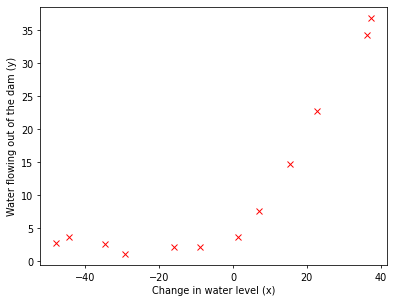

In [142]:
def plot_data(gdata): 
    fig,axes = plt.subplots(dpi=70)
    x,y = gdata.get_trxy(insert_one=False)
    axes.plot(x,y,"rx")
    axes.set_xlabel("Change in water level (x)")
    axes.set_ylabel("Water flowing out of the dam (y)")
    plt.plot()
    return None
plot_data(gdata)

### Cost and Gradient

In [143]:
X,y = gdata.get_trxy()
def re_cost(theta,X,y,lamda=0):
    m = X.shape[0]
    cost = 0.5*np.power((X@theta[:,None]-y),2).mean()
    cost_rgu = (lamda/(2*m))*np.power(theta[1:],2).sum()
    gradient = (1/m)*((X@theta[:,None]-y).T@X).flatten()
    gradient_rgu = np.insert((lamda/m)*theta[1:],obj=0,values=0,axis=0)
    return cost+cost_rgu, gradient+gradient_rgu
re_cost(theta,X,y)

(303.9515255535976, array([-15.30301567, 598.16741084]))

In [144]:
res = opt.minimize(re_cost,x0=theta,args=(X,y),method="Newton-CG",jac=True)

In [146]:
final_theta = res.x

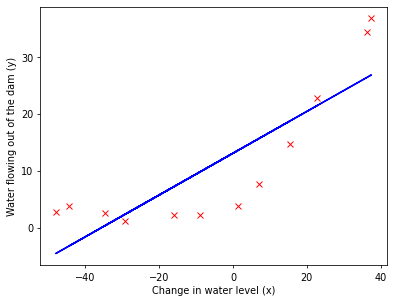

In [147]:
def plot_hbias(gdata,theta): 
    fig,axes = plt.subplots(dpi=70)
    x,y1 = gdata.get_trxy(insert_one=False)
    y2 = [theta[0]+theta[1]*i for i in x]
    axes.plot(x,y1,"rx")
    axes.plot(x,y2,"b-")
    axes.set_xlabel("Change in water level (x)")
    axes.set_ylabel("Water flowing out of the dam (y)")
    plt.plot()
    return None
plot_hbias(gdata,final_theta)

### Learning Curve of high bias

In [158]:
# 'tx' and 'ty' are the training data and labels, respectively.
# 'vx' and 'vy' are the validation data and labels, respectively.
tx,ty = gdata.get_trxy()
vx,vy = gdata.get_vcxy()

# 'theta' is the initial parameter vector.
theta = get_theta(tx.shape[1])

# Define a function 'learning_curve' to compute the training and validation errors for different sizes of the training set.
# 'theta' is the initial parameter vector.
# 'tx' and 'ty' are the training data and labels.
# 'vx' and 'vy' are the validation data and labels.
# 'lamda' is the regularization parameter.
def learning_curve(theta,tx,ty,vx,vy,lamda=1):
    # Initialize the lists 'tr_errs' and 'cv_errs' to store the training and validation errors, respectively.
    tr_errs = []
    cv_errs = []
    # 'm' is the number of training examples.
    m = tx.shape[0]
    # 'res' is a function that uses the 'minimize' function from the 'scipy.optimize' module to find the parameters that minimize the cost function.
    res = partial(opt.minimize,fun=re_cost,x0=theta,method="TNC",jac=True,options={'disp':True})
    # For each training example, compute the training and validation errors and append them to 'tr_errs' and 'cv_errs', respectively.
    for index, _ in enumerate(tx):
        # 'tem_theta' is the parameter vector that minimizes the cost function for the current subset of the training data.
        tem_theta = res(args=(tx[0:index+1,:],ty[0:index+1,:],lamda)).x
        # 'tr_err' is the training error for the current subset of the training data.
        tr_err = re_cost(tem_theta,tx[0:index+1,:],ty[0:index+1,:],lamda=0)[0]
        # 'cv_err' is the validation error for the current subset of the training data.
        cv_err = re_cost(tem_theta,vx,vy,lamda=0)[0]
        # Append 'tr_err' and 'cv_err' to 'tr_errs' and 'cv_errs', respectively.
        tr_errs.append(tr_err)
        cv_errs.append(cv_err)
    # Return 'tr_errs' and 'cv_errs' as numpy arrays.
    return np.array(tr_errs), np.array(cv_errs)

In [159]:
errs = learning_curve(theta,tx,ty,vx,vy)

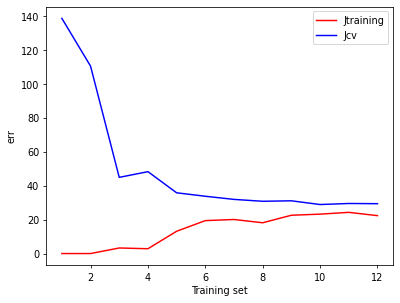

In [160]:
def plot_lcurve(errs): 
    fig,axes = plt.subplots(dpi=70)
    x = np.arange(1,len(errs[0])+1,step=1)
    tr = errs[0]
    cv =errs[1]
    axes.plot(x,tr,"r-",label="Jtraining")
    axes.plot(x,cv,"b-",label="Jcv")
    axes.set_xlabel("Training set")
    axes.set_ylabel("err")
    axes.legend()
    plt.plot()
    return None
plot_lcurve(errs)

### Learning Curve of ploy x with different 𝜆

In [270]:
# Define a function 'ploy_map' to map the features into polynomial features and normalize them.
# '*args' are the input features.
# 'insert_ones' is a boolean flag to decide whether to insert a column of ones for the bias term.
# 'power' is the degree of the polynomial.
def ploy_map(*args,insert_ones=True,power):
    # Define a function 'ploy_it' to map a single feature 'x' into polynomial features and normalize them.
    def ploy_it(x):
        # Use a dictionary comprehension to create a dictionary 'res' where the keys are the feature names and the values are the polynomial features.
        res = {'f{}'.format(i):np.power(x.flatten(),i) for i in range(1,power+1) }
        # Convert 'res' into a DataFrame, normalize the features, and convert the DataFrame back into a numpy array 'df'.
        df = pd.DataFrame(res).apply(lambda col: (col-col.mean())/col.std()).to_numpy()
        # If 'insert_ones' is True, insert a column of ones at the beginning of 'df' for the bias term.
        if insert_ones:df = np.insert(df,obj=0,values=1,axis=1)
        # Return 'df'.
        return df
    # Apply 'ploy_it' to each feature in '*args' and return the results as a list.
    return [ploy_it(x) for x in args]

In [271]:
X,cvx,tex = gdata.get_allx()
y,cvy,tey = gdata.get_ally()
X,cvx,tex = ploy_map(X,cvx,tex,power=8)
theta = get_theta(X.shape[1])

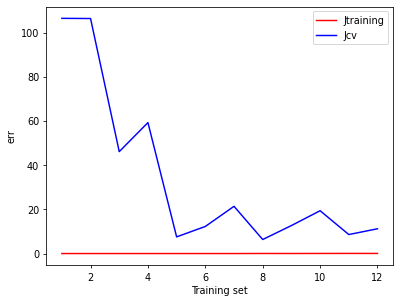

In [272]:
errs = learning_curve(theta,X,y,cvx,cvy,lamda=0) 
def plot_lcurve(errs): 
    fig,axes = plt.subplots(dpi=70)
    x = np.arange(1,len(errs[0])+1,step=1)
    tr = errs[0]
    cv =errs[1]
    axes.plot(x,tr,"r-",label="Jtraining")
    axes.plot(x,cv,"b-",label="Jcv")
    axes.set_xlabel("Training set")
    axes.set_ylabel("err")
    axes.legend()
    plt.plot()
    return None
plot_lcurve(errs)

### choice best 𝜆 with $J_{train}$ and $J_{cv}$

In [166]:
# Define a function 'choice_btlamda' to compute the training and validation errors for different values of the regularization parameter 'lamda'.
# 'lamdas' is a list of values for the regularization parameter.
# 'theta' is the initial parameter vector.
# 'X' and 'y' are the training data and labels.
# 'cvx' and 'cvy' are the validation data and labels.
def choice_btlamda(lamdas,theta,X,y,cvx,cvy):
    # Initialize the lists 'tr_list' and 'cv_list' to store the training and validation errors, respectively.
    tr_list = []
    cv_list = []
    # Define a function 'cpt_theta' to compute the parameter vector that minimizes the cost function.
    def cpt_theta(theta,X,y,lamda):
        # Use the 'minimize' function from the 'scipy.optimize' module to find the parameters that minimize the cost function.
        res = opt.minimize(re_cost,x0=theta,
                           args=(X,y,lamda),
                           method='TNC',
                           jac=True,
                           options={'disp':True}) 
        return res.x
    # For each value of 'lamda' in 'lamdas', compute the training and validation errors and append them to 'tr_list' and 'cv_list', respectively.
    for lamda in lamdas:
        # Compute the parameter vector 'cu_theta' that minimizes the cost function for the current value of 'lamda'.
        cu_theta = cpt_theta(theta,X,y,lamda)
        # Compute the training and validation errors 'jtrain' and 'jcv' for the current value of 'lamda'.
        jtrain,_ = re_cost(cu_theta,X,y,0)
        jcv ,_= re_cost(cu_theta,cvx,cvy,0)
        # Append 'jtrain' and 'jcv' to 'tr_list' and 'cv_list', respectively.
        tr_list.append(jtrain)
        cv_list.append(jcv)
    # Return 'tr_list' and 'cv_list'.
    return tr_list, cv_list

In [172]:
lamdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
theta = get_theta(X.shape[1])
errs = choice_btlamda(lamdas,theta,X,y,cvx,cvy)

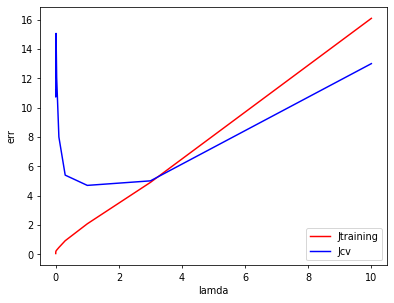

In [173]:
def plot_lcurve(errs,lamdas): 
    fig,axes = plt.subplots(dpi=70)
    x = lamdas
    tr = errs[0]
    cv =errs[1]
    axes.plot(x,tr,"r-",label="Jtraining")
    axes.plot(x,cv,"b-",label="Jcv")
    axes.set_xlabel("lamda")
    axes.set_ylabel("err")
    axes.legend()
    plt.plot()
    return None
plot_lcurve(errs,lamdas)

### Get the $J_{test}$

In [188]:
def get_jtest(theta,X,y,tex,tey,lamda):
    def cpt_theta(theta,X,y,lamda):
        res = opt.minimize(re_cost,x0=theta,
                           args=(X,y,lamda),
                           method='TNC',
                           jac=True,
                           options={'disp':True}) 
        return res.x
    final_theta = cpt_theta(theta,X,y,lamda)
    jtest, _ = re_cost(final_theta,tex,tey,lamda=0)
    return jtest
theta = get_theta(tex.shape[1])
get_jtest(theta,X,y,tex,tey,lamda=3)

11.64392809759291

In [193]:
tcost = partial(get_jtest,theta=theta,X=X,y=y,tex=tex,tey=tey)
for lamda in lamdas:
    print(f'when lamda={lamda},Jtest == {tcost(lamda=lamda)}')

when lamda=0,Jtest == 10.047024076473404
when lamda=0.001,Jtest == 11.050951936301145
when lamda=0.003,Jtest == 11.260052610105248
when lamda=0.01,Jtest == 10.878685963523106
when lamda=0.03,Jtest == 10.022502843406501
when lamda=0.1,Jtest == 8.63204962258897
when lamda=0.3,Jtest == 7.33672362393468
when lamda=1,Jtest == 7.4662936072294155
when lamda=3,Jtest == 11.64392809759291
when lamda=10,Jtest == 27.7150802657058


### Learning curve of ramdom

In [262]:
# Define a function 'rng_lcurve' to compute the training and validation errors for different sizes of the training set using random sampling.
# 'theta' is the initial parameter vector.
# 'X' and 'y' are the training data and labels.
# 'cvx' and 'cvy' are the validation data and labels.
# 'lamda' is the regularization parameter.
def rng_lcurve(theta,X,y,cvx,cvy,lamda):
    # Initialize the lists 'tr_list' and 'cv_list' to store the training and validation errors, respectively.
    tr_list = []
    cv_list = []
    # Initialize a random number generator 'rng'.
    rng = np.random.default_rng()
    # Define a function 'cpt_theta' to compute the parameter vector that minimizes the cost function.
    def cpt_theta(theta,X,y,lamda):
        # Use the 'minimize' function from the 'scipy.optimize' module to find the parameters that minimize the cost function.
        res = opt.minimize(re_cost,x0=theta,
                           args=(X,y,lamda),
                           method='TNC',
                           jac=True,
                           options={'disp':True}) 
        return res.x
    # For each training example, compute the training and validation errors using random sampling and append them to 'tr_list' and 'cv_list', respectively.
    for index, _ in enumerate(X):
        acc_jtrain = 0
        acc_cv = 0
        # Repeat the process 50 times for each training example.
        for i in range(50):
            # Randomly select 'index+1' examples from the training and validation sets.
            xy = rng.choice(np.hstack((X,y)),size=index+1,replace=False,axis=0)
            vxy = rng.choice(np.hstack((cvx,cvy)),size=index+1,replace=False,axis=0)
            # Split the selected examples into features 'xi' and 'vxi' and labels 'yi' and 'vyi'.
            xi, yi = xy[:,:-1], xy[:,[-1]]
            vxi, vyi = vxy[:,:-1], vxy[:,[-1]] 
            # Compute the parameter vector 'cu_theta' that minimizes the cost function for the selected training examples.
            cu_theta = cpt_theta(theta,xi,yi,lamda)
            # Compute the training and validation errors 'tem_jtrain' and 'tem_cv' for the selected training examples.
            tem_jtrain, _ = re_cost(cu_theta,xi,yi,lamda=0)
            tem_cv, _ = re_cost(cu_theta,vxi,vyi,lamda=0)
            # Compute the average training and validation errors 'acc_jtrain' and 'acc_cv' over the 50 repetitions.
            acc_jtrain = np.mean((acc_jtrain, tem_jtrain)) 
            acc_cv = np.mean((acc_cv, tem_cv))
        # Append 'acc_jtrain' and 'acc_cv' to 'tr_list' and 'cv_list', respectively.
        tr_list.append(acc_jtrain)
        cv_list.append(acc_cv)
    # Return 'tr_list' and 'cv_list'.
    return tr_list, cv_list

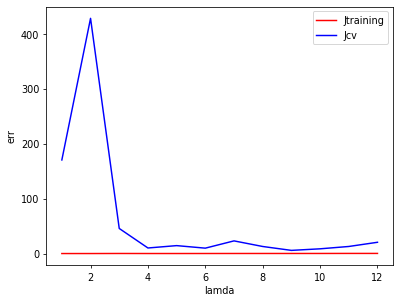

In [269]:
errs = rng_lcurve(theta,X,y,cvx,cvy,lamda=0.01)
def plot_lcurve(errs): 
    fig,axes = plt.subplots(dpi=70)
    x = np.arange(1,len(errs[0])+1)
    tr = errs[0]
    cv =errs[1]
    axes.plot(x,tr,"r-",label="Jtraining")
    axes.plot(x,cv,"b-",label="Jcv")
    axes.set_xlabel("lamda")
    axes.set_ylabel("err")
    axes.legend()
    plt.plot()
    return None
plot_lcurve(errs)